# Домашнее задание к уроку "Сегментация и детекция объектов"

Распознавание рукописного ввода на примере базы MNIST.

Построить классификатор изображений рукописного ввода на базе MNIST (https://www.kaggle.com/c/digit-recognizer).

В качестве модели классификатора можно использовать любую известную модель, за исключением сверточных нейронных сетей.

Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.

In [1]:
import numpy as np
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from IPython.display import Image

Загружаем данные MNIST

In [2]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1, dtype=np.float32)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1, dtype=np.float32)
y = np.array(train[:, 0], dtype=np.int8)
X = np.resize(train[:, 1:], (train.shape[0], 28, 28))
X_test = np.resize(test, (test.shape[0], 28, 28))

Визуализируем данные

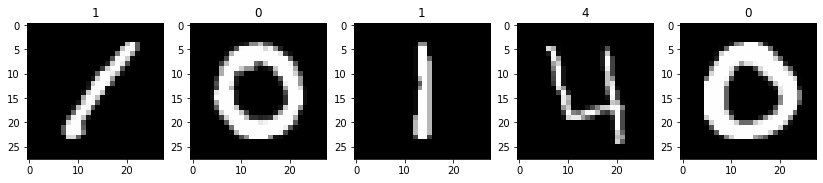

In [3]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y[i - 1])

Создадим класс для предобработки данных. В качестве признаков будем использовать гистрограмму градиентов и признаки из PCA-преобразования.

In [4]:
class PrepareMNISTData:
    """ Класс для подготовки данных к обучению модели
    
    Параметры
    ---------
    pca_components : int
      Число главных компонент PCA для разложения признаков изображения MNIST.
      По умолчанию 30.
    grad_hist_bins : int
      Количество бинов для гистраграммы градиентов.
      По умолчанию 16.
    """
    def __init__(self, pca_components=30, grad_hist_bins=16):
      self.pca_components = pca_components
      self._pca = PCA(n_components=self.pca_components)
      self._grad_hist_bins = grad_hist_bins
    

    def _get_gradient_hist(self, X):
      """ Формирование блока признаков с градиентами

      Параметры
      ---------
      X : array
        Изображения MNIST в формате матрицы размером (p, h, w).
        n - количество образцов
        h - высотка изображения
        w - ширина изображения

      Результат
      ---------
      X_hist : array
        Гистограммы изображений в формате матрицы размером (n, k)
        n - количество чисел
        k - кол-во бинов гистограммы
      """

      # Находим градиенты с помощью оператора Собеля
      train_sobel_x = np.zeros_like(X)
      train_sobel_y = np.zeros_like(X)
      for i in range(len(X)):
          train_sobel_x[i] = cv2.Sobel(X[i], cv2.CV_32F, dx=1, dy=0, ksize=3)
          train_sobel_y[i] = cv2.Sobel(X[i], cv2.CV_32F, dx=0, dy=1, ksize=3)
      train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

      # Гистограммы вычисляются с учетом длины вектора градиента
      X_hist = np.zeros((len(X), self._grad_hist_bins))
      for i in range(len(X)):
          hist, borders = np.histogram(train_theta[i],
                                        bins=self._grad_hist_bins,
                                        range=(0., 2. * np.pi),
                                        weights=train_g[i])
          X_hist[i] = hist
          
      # Нормализация гистограмм
      X_hist = X_hist / np.linalg.norm(X_hist, axis=1)[:, None]
          
      return X_hist
    
    
    def _make_pca_features(self, X, mode='train'):
      """ Формирование блока признаков с градиентами

      Параметры
      ---------
      X : array
        Изображения MNIST в формате матрицы размером (p, h, w).
        n - количество образцов
        h - высотка изображения
        w - ширина изображения
      mode : str
        Режим работы. Если mode = 'train', то перед преобразованием
        модель PCA будет обучена на данных из X. Иначе преобразование
        будет сделано без обучения на текущей модели.

      Результат
      ---------
      X_pca : array
        PCA-признаки изображений в формате матрицы размером (n, k)
        n - количество чисел
        k - кол-во главных компонент PCA
      """

      mode = str(mode).lower().strip()

      img_count, img_height, img_width = X.shape
      assert img_height*img_width >= self.pca_components, "Количество главных компонент превышает кол-во признаков изображения"

      X_pca = np.reshape(X, (img_count, -1))
      
      if mode == 'train':
          X_pca = self._pca.fit_transform(X_pca)
      else:
          X_pca = self._pca.transform(X_pca)
          
      return X_pca

    
    def fit_transform(self, X):
      """ Функция для обучения PCA и трансформации тренировочных данных 
      
      Параметры
      ---------
      X : array
        Изображения MNIST в формате матрицы размером (p, h, w).
        n - количество образцов
        h - высотка изображения
        w - ширина изображения

      Результат
      ---------
      X_prepared : array
        Набор признаков для обучения для каждой цифры в формате
        матрицы размером (n, k)
        n - количество чисел
        k - кол-во признаков чисел
      """
      X = np.array(X)
      photo_hist = self._get_gradient_hist(X)
      pca_data = self._make_pca_features(X, mode='train')
      return np.hstack((photo_hist, pca_data))
    
    
    def transform(self, X):
      """ Трансформация данных MNIST на обученных моделях

      Параметры
      ---------
      X : array
        Изображения MNIST в формате матрицы размером (p, h, w).
        n - количество образцов
        h - высотка изображения
        w - ширина изображения

      Результат
      ---------
      X_prepared : array
        Набор признаков для обучения для каждой цифры в формате
        матрицы размером (n, k)
        n - количество чисел
        k - кол-во признаков чисел
      """
      photo_hist = self._get_gradient_hist(X)
      pca_data = self._make_pca_features(X, mode='test')
      return np.hstack((photo_hist, pca_data))

Разделим данные на обучающую и валидационную части, подготовим данные для обучения через класс PrepareMNISTData

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,
                                                  stratify=y, random_state=42)
mod = PrepareMNISTData(pca_components=50, grad_hist_bins=16)
X_train_prep = mod.fit_transform(X_train)
X_val_prep = mod.transform(X_val)
X_test_prep =mod.transform(X_test) 

В качестве модели выберем RandomForestClassifier. Попробуем обучить модель и получить метрику accuracy

In [6]:
ensemble = RandomForestClassifier(n_estimators=200, random_state=42)
ensemble.fit(X_train_prep, y_train)
y_pred = ensemble.predict(X_val_prep)
print('accuracy score:', accuracy_score(y_val, y_pred))

accuracy score: 0.9570238095238095


В результате получили достаточно высокую метрику accuracy_score. Посмотрим на матрицу ошибок.

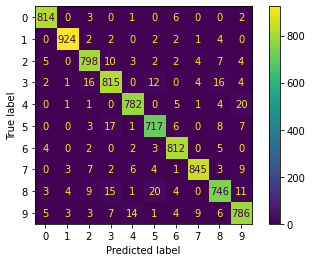

In [7]:
plot_confusion_matrix(ensemble, X_val_prep, y_val)
plt.show()

Как видно из матрицы мы чаще всего путаем четверку с девяткой, тройку с пятеркой и восьмерку с тройкой.

# Предсказания на тестовых данных

In [8]:
y_pred_test = ensemble.predict(X_test_prep)

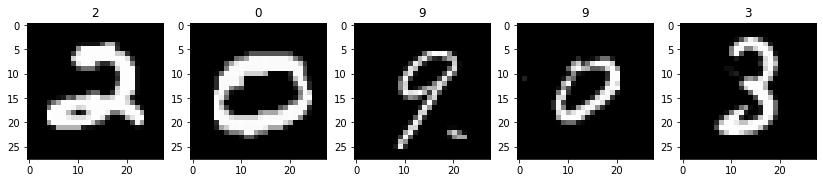

In [9]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(X_test[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_pred_test[i - 1])

Готовим файл для отправки

In [10]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(y_pred_test, 1):
        dst.write('%s,%s\n' % (i, p))

Результат работы на Kaggle

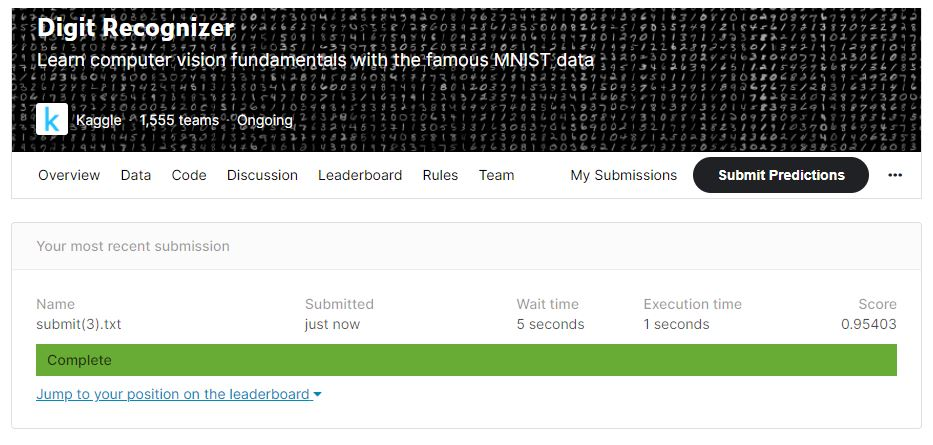

In [11]:
Image("kaggle_result.jpg")